# Assumptions

- Equidistanced spatial grid

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

#### Configure time array

In [2]:
t0 = 0.0
Nt = 201
dt = 0.05

t_arr = t0 + dt*np.arange(Nt)
print("time range: [{}, {}] a.u.".format(*t_arr[[0,-1]]))

time range: [0.0, 10.0] a.u.


#### Configure spatial array

In [3]:
Nx = 401
x_arr = np.linspace(0, 5.1, Nx)
dx = x_arr[1] - x_arr[0]
L = x_arr[-1] - x_arr[0]
print("dx: {}".format(dx))

# Set limit beyond which particles stop
lowerx, upperx = x_arr[1], x_arr[-2]

dx: 0.01275


#### Configure spatial potential energy

In [4]:
Vx = np.zeros_like(x_arr, dtype=float)

#### Configure initial state

In [5]:
wf_x_t0 = np.empty_like(x_arr, dtype=complex)
wf_x_t0[:] = np.sin(pi/L*x_arr) + 0.3*np.sin(2*pi/L*x_arr)
wf_x_t0 /= np.sqrt(np.trapz(np.square(np.abs(wf_x_t0)), x_arr))

#### Configure unit

In [6]:
hbar, m = 1.0, 1.0

#### Configure propagator

In [7]:
from tdse.prop.propagator import Time_Indep_Hamil_Propagator

prop = Time_Indep_Hamil_Propagator(Nx-2, dx, Vx[1:-1], m=1.0)

#### Configure particles

In [8]:
xp_t0_arr = np.linspace(x_arr[2], x_arr[-3], 11)

# Propagate

In [9]:
from warnings import filterwarnings
filterwarnings('error')

# [TODO] Check why the root-finding does not stop even though the function value is almost zero such as `1e-17`. See something near check tolerance and check end condition like `f_norm< f_rtol * |F_0|`

- [OBSERVATION] Turns out, at least it seems like, the default value of `fatol`, which is one of the options provicded by `broyden1` method, doesn't seem to have `6e-6` as a default value, but is set to `np.inf` by default. Thus, the user need to set it. This behaviour should be verified. - yes indeed, it was. The [scipy document](https://docs.scipy.org/doc/scipy/reference/optimize.root-broyden1.html#optimize-root-broyden1) may have a small inconsistency with actual code.  => NOPE, but the it was true, it was consistent in a sense the root-finding routine contains TerminationCondition object and inside the absolute f threshold is set `np.finfo(np.float_).eps ** (1./3)` by default.

In [40]:
import importlib
importlib.reload(scipy.optimize.nonlin)
from scipy.optimize import root

In [10]:
# Initialize
xp_arr = np.empty_like(xp_t0_arr)
xp_arr[:] = xp_t0_arr
xp_arr_t = np.zeros((Nt, xp_arr.size))
xp_arr_t[0,:] = xp_arr

wf_x = np.empty_like(wf_x_t0)
wf_x[:] = wf_x_t0
wf_x_t = np.zeros((Nt,wf_x.size), dtype=wf_x.dtype)
wf_x_t[0,:] = wf_x


# Arrays for Finite Difference method
Ns = 3
A = np.empty((Ns,Ns), dtype=float)
A[:,0] = 1.
b = np.empty((Ns,), dtype=complex)


assert np.std(np.diff(x_arr)) < 1e-8 * np.mean(x_arr)

g_func, g_args = None, None
dxp_g_list = None


# iteration over time
from scipy.optimize import root
for it in range(Nt):
#     print("time-index: {}".format(it))
    prop.propagate(wf_x[1:-1], dt, Nt=1)
    
    for ip, xp in enumerate(xp_arr):
#         print("particle-index: {} / particle-position: {}".format(ip, xp))
        if not (lowerx < xp and xp < upperx): continue

            
        def _g_func(_dxp, _xp, _x_arr, _wf_arr, _dt, _A, _b, _hbar, _m, lowers, uppers, rfac=1e-3, _vv=False):
            
            # Adjust `_dxp` into valid range if not
            _dx_l, _dx_u = lowers - _dxp, _dxp - uppers
            _ll, _uu = (_dx_l > 0) * _dx_l, (_dx_u > 0) * _dx_u
            _dxp += _ll - _uu
            # Evalaute a factor to be multiplied to funcion value if `_dxp` is out of range
            _g_factor = 1. + rfac * (_ll + _uu)
            
            
            _dx = _x_arr[1] - _x_arr[0]
            _x = _xp + _dxp
            
            _is0 = int((_x-_x_arr[0])//_dx)
            _Nx = _wf_arr.size
            if _is0 > _Nx//2: _is0 += -1
            _xi_minus_x = (_x_arr[_is0:_is0+Ns] - _x)
            if _vv: print("_dxp={}, _xp={}, _x={}, _is0={}, _xi_minus_x={}, _A[:,0]={}".format(
                _dxp, _xp, _x, _is0, _xi_minus_x, _A[:,0]))
            _A[:,1] = _A[:,0] * _xi_minus_x / 1.
            _A[:,2] = _A[:,1] * _xi_minus_x / 2.
            _b[:] = _wf_arr[_is0:_is0+Ns]
            
            try: _wf, _dx_wf, _dx2_wf = np.linalg.solve(_A, _b)
            except np.linalg.LinAlgError as e:
                raise RuntimeError("Failed to get wf at given x: {}".format(_x))
            except: raise Exception("Unexpected error")
                
            if _wf == 0: raise NotImplementedError
                
            _v = _hbar / _m * np.imag(_dx_wf / _wf)
            
            _g = -_dxp + _dt * _v
            
            # For extension if `_dxp` is out of range
            _g *= _g_factor
            return _g
        
        _g_args = (xp, x_arr, wf_x, dt, A, b, hbar, m, lowerx-xp, upperx-xp, 1e-3)
        
        _dxp_g_list = []
        def callback(dxp,g): _dxp_g_list.append((dxp[0],g[0])), print(dxp,g)
#         _opt_broyden1 = {'xtol':1e-4, 'xatol':1e2, 'fatol':6e-3, 'ftol':1e4, 'nit':200}
        _opt_broyden1 = {'xtol':1e0,'nit':200}
    
        _tot_opt = { 'method':'broyden1', 'options': _opt_broyden1}
        
        _failed = False
        try: _sol = root(_g_func, 0.0, _g_args, **_tot_opt)
        except Exception as e:
            _tot_opt_at_err = { 'method':'broyden1', 'options': {**_opt_broyden1, 'disp':True}}
            try: 
                _g_args_at_err = _g_args + (True,)
#                 print("_g_args_at_err: ",_g_args_at_err)
                _sol = root(_g_func, 0.0, _g_args_at_err, callback=callback, **_tot_opt_at_err)
            except: pass
            
            g_func, g_args = _g_func, _g_args
            dxp_g_list = _dxp_g_list
            
            _msg = "Failed for time-index={}, particle-position={:.4f}\n"
            raise Exception(_msg.format(it, xp))
            
        if not _sol.success:
            try: _sol = root(_g_func, 0.0, _g_args, callback=callback, **_tot_opt)
            except: pass
            g_func, g_args = _g_func, _g_args
            dxp_g_list = _dxp_g_list
            _msg = "Failed for time-index={}, particle-position={:.4f}\nopt_result:\n{}"
            raise Exception(_msg.format(it, xp, _sol))
            
        _dxp = _sol.x
        xp_arr[ip] += _dxp
        
        
        # Store
        xp_arr_t[it,:] = xp_arr
        wf_x_t[it,:] = wf_x

#### Visualize

In [11]:
pdf_x_t = np.square(np.abs(wf_x_t))

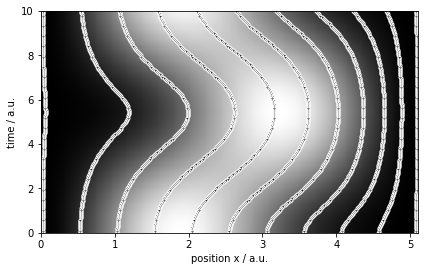

In [12]:
fig, ax = plt.subplots()

img_extent = (*x_arr[[0,-1]], *t_arr[[0,-1]])
ax.imshow(pdf_x_t, origin='lower', extent=img_extent, cmap='gray')
ax.set_aspect(0.3)

for ip in range(xp_t0_arr.size):
    ax.plot(xp_arr_t[:,ip], t_arr, '.', color='white', mfc='black')
    
ax.set_xlabel("position x / a.u."), ax.set_ylabel("time / a.u.")
fig.tight_layout()

# fig.savefig("particles-test-10.png")

# [TODO] Seems like, the RuntimeWarning arise due to np.inf / np.inf which yields nan. The np.inf in the denominator is `x_rtol` and if it is set, it would be good to go. Let's check if it is true. => YES. When I set `x_rtol`, the RuntimeWarning dissapeared and the root-finding went smoothly.

In [13]:
2.4e-6 <= 6e-06

True

In [14]:
2.4e-6 / np.inf

0.0

In [15]:
np.inf < np.inf

False

In [16]:
(np.inf / np.inf) <= 0.0

False

In [17]:
np.inf / 1e-4 > 0.0

True

# ETC>

In [32]:
g_args[0]

0.025558518771708824

In [33]:
g_func(0.0, *g_args)

3.9206801181068846e-05

In [35]:
dxp_g_arr = np.asarray(dxp_g_list)
dxp_g_arr

array([], dtype=float64)

In [29]:
if dxp_g_arr.size > 0:
    np.average(dxp_g_arr[:,1])

(-5e-05, 5e-05)

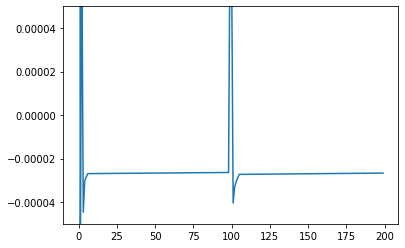

In [30]:
fig, ax = plt.subplots()
ax.plot(dxp_g_arr[:,1])
# ax2 = ax.twinx()
# ax2.plot(np.diff(dxp_g_arr[:,1]), color='darksalmon')
ax.set_ylim(-0.00005, 0.00005)

In [55]:
xp = g_args[0]
x_minus_xp_arr = x_arr - xp

In [38]:
dxp_g_median = np.median(dxp_g_arr[:,0])
dxp_arr = np.linspace(dxp_g_median-0.0001,dxp_g_median+0.0001,101)
g_arr = np.asarray([g_func(dxp, *g_args) for dxp in dxp_arr])

NameError: name 'dxp_arr' is not defined

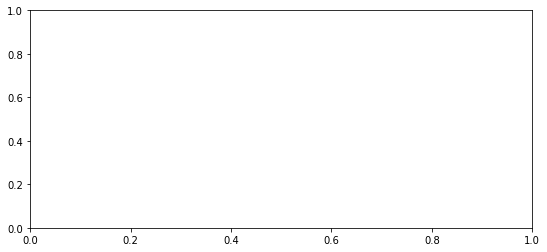

In [12]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(dxp_arr, g_arr, '.', label='g(dxp)')
ax.set_ylim(*ax.get_ylim())
ax.set_xlim(*dxp_arr[[0,-1]])

ax.vlines(x_minus_xp_arr, *ax.get_ylim(), linestyle='--', linewidth=0.8, label='xp+dxp == x grid points')

ax.plot(dxp_arr[[0,-1]], [0,0], '--', color='gray')
if dxp_g_arr.size > 0:
    ax.plot(dxp_g_arr[:,0], dxp_g_arr[:,1], '.', label='root-finding trials')
    
ax.legend()
ax.set_xlabel("position displacement for next time step: dxp / a.u.", fontsize='large')
ax.set_ylabel("objective function to be zero / a.u.", fontsize='large')
fig.tight_layout()
# fig.savefig("discontinuous-nature-of-obj-func-to-be-zero-test-2.png")

# [..may be not][TODO] Let's just use jacobian instead of approximation, since it isn't too hard to evaluate

#### Animate propagation

In [ ]:
# %matplotlib notebook

# from matplotlib.animation import FuncAnimation

In [ ]:
# fig, ax = plt.subplots()

# l_real, = ax.plot([],[])
# l_abs, = ax.plot([],[])
# ax.set_xlim(*x_arr[[0,-1]]), ax.set_ylim(-1,1)
# text = ax.text(0,0,'')

# def init(): 
#     wf_x[:] = wf_x_t0
#     l_real.set_data(x_arr, wf_x.real)
#     l_abs.set_data(x_arr, np.abs(wf_x))
#     return l_real, l_abs
    
# def update(i):
#     prop.propagate(wf_x[1:-1], dt, Nt=10)
#     l_real.set_data(x_arr, wf_x.real)
#     l_abs.set_data(x_arr, np.abs(wf_x))
#     text.set_text(i)

# ani = FuncAnimation(fig, update, frames=15, init_func=init)